In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time


In [2]:

# Set some visual styles for our plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [3]:

# Load the dataset
try:
    data = pd.read_csv('measures_v2.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'pmsm_temperature_data.csv' not found. Please download it and place it in the correct directory.")

# Display the first few rows to see what it looks like
print("First 5 rows of the dataset:")
print(data.head())

# Display column names to check for any weird characters or spaces
print("\nColumn Names:")
print(data.columns)

Dataset loaded successfully!
First 5 rows of the dataset:
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.20

In [4]:
# Get technical information about the DataFrame
print("\n--- Data Info ---")
data.info()

# Get descriptive statistics for all numerical columns
print("\n--- Descriptive Statistics ---")
print(data.describe().T) # .T transposes the output for better readability



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB

--- Descriptive Statistics ---
                    count         mean          std         min         25%  \


--- Plotting Feature Distributions ---


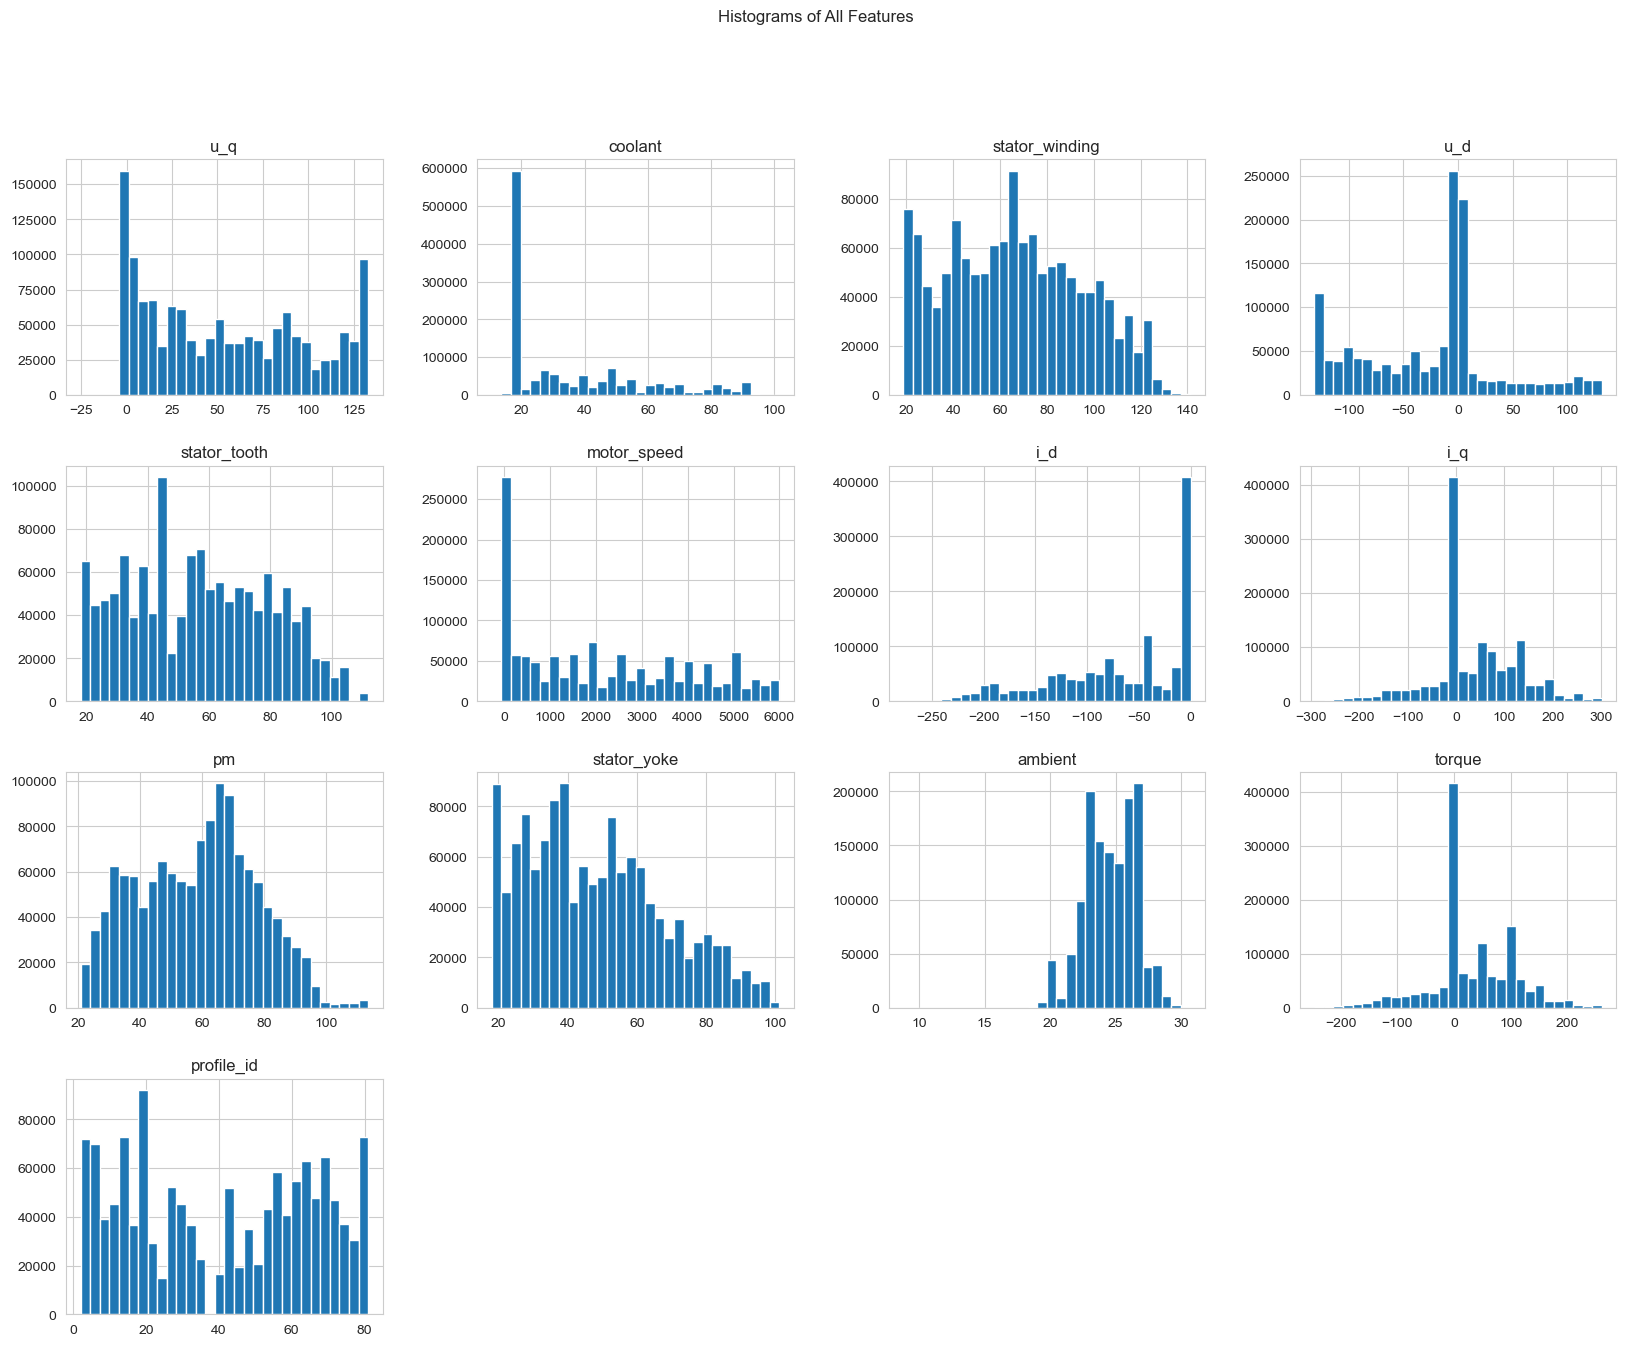

In [5]:

# Plot histograms for all features
print("\n--- Plotting Feature Distributions ---")
data.hist(bins=30, figsize=(20, 15))
plt.suptitle("Histograms of All Features")
plt.show()



--- Plotting Box Plots for Outlier Detection ---


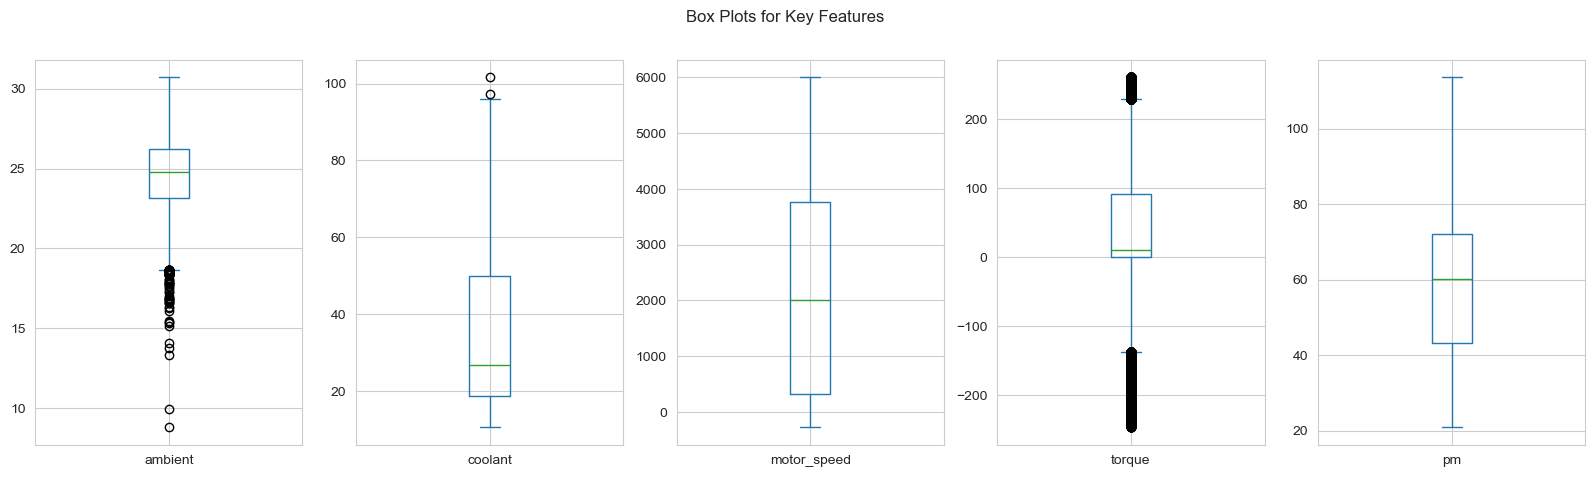

In [6]:

# Plot box plots to check for outliers
print("\n--- Plotting Box Plots for Outlier Detection ---")
# Select a subset of columns for clarity, or plot them all
columns_to_plot = ['ambient', 'coolant', 'motor_speed', 'torque', 'pm']
data[columns_to_plot].plot(kind='box', subplots=True, layout=(1, 5), figsize=(20, 5))
plt.suptitle("Box Plots for Key Features")
plt.show()

In [7]:


# Assuming your dataframe is called df and column is 'ambient'

Q1 = data['ambient'].quantile(0.25)
Q3 = data['ambient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")


Lower Bound: 18.636482539859912
Upper Bound: 30.765340939019296


In [8]:
outliers = data[(data['ambient'] < lower_bound) | (data['ambient'] > upper_bound)]
print(outliers)


               u_q    coolant  stator_winding         u_d  stator_tooth  \
53146    98.256256  19.117596       32.877953  -79.264999     29.254145   
53195    98.209297  18.630608       33.569157  -79.226288     29.881760   
53196    98.224442  18.622042       33.578583  -79.200272     29.893639   
53197    98.233444  18.617403       33.589199  -79.189255     29.871994   
53198    98.243469  18.603586       33.644070  -79.168190     29.865429   
...            ...        ...             ...         ...           ...   
1239083  -1.835686  35.431062       54.569053    2.075659     53.301141   
1239084  -1.739932  37.750187       54.602352    2.048448     53.300281   
1258649  54.086874  23.377345       72.121722   58.361855     61.355401   
1258650  53.127415  28.011328       72.121724   57.124542     61.367160   
1323543  60.724390  55.504201       94.861235 -111.864813     84.927972   

         motor_speed         i_d         i_q         pm  stator_yoke  \
53146    2249.993164  -33.0

**Removing the outlier from the ambient**

In [9]:
# Calculate distance from bounds
data['distance_lower'] = lower_bound - data['ambient']
data['distance_upper'] = data['ambient'] - upper_bound

# Set negative distances to 0 because those are not outliers on that side
data['distance_lower'] = data['distance_lower'].apply(lambda x: x if x > 0 else 0)
data['distance_upper'] = data['distance_upper'].apply(lambda x: x if x > 0 else 0)

# Take max distance per row as the "outlier distance"
data['outlier_distance'] = data[['distance_lower', 'distance_upper']].max(axis=1)

# Sort by outlier_distance descending and get top 2 indices
top2_outliers_idx = data.sort_values(by='outlier_distance', ascending=False).head(10).index

# Drop those 2 outliers
data_cleaned = data.drop(index=top2_outliers_idx)

# Drop helper columns if you want
data = data_cleaned.drop(columns=['distance_lower', 'distance_upper', 'outlier_distance'])

print(data)


              u_q    coolant  stator_winding       u_d  stator_tooth  \
0       -0.450682  18.805172       19.086670 -0.350055     18.293219   
1       -0.325737  18.818571       19.092390 -0.305803     18.294807   
2       -0.440864  18.828770       19.089380 -0.372503     18.294094   
3       -0.327026  18.835567       19.083031 -0.316199     18.292542   
4       -0.471150  18.857033       19.082525 -0.332272     18.291428   
...           ...        ...             ...       ...           ...   
1330811 -2.152128  30.721298       45.274497  0.791801     41.934347   
1330812 -2.258684  30.721306       45.239017  0.778900     41.868923   
1330813 -2.130312  30.721312       45.211576  0.804914     41.804819   
1330814 -2.268498  30.721316       45.193508  0.763091     41.762220   
1330815 -2.100158  30.721319       45.132307  0.807309     41.734763   

         motor_speed       i_d       i_q         pm  stator_yoke    ambient  \
0           0.002866  0.004419  0.000328  24.554214    1

ambient    Axes(0.125,0.11;0.133621x0.77)
dtype: object

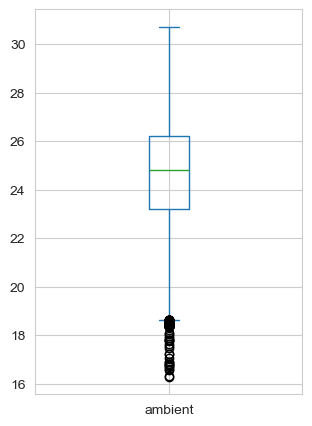

In [10]:
data["ambient"].plot(kind='box', subplots=True, layout=(1, 5), figsize=(20, 5))

Performing multivariate analysis

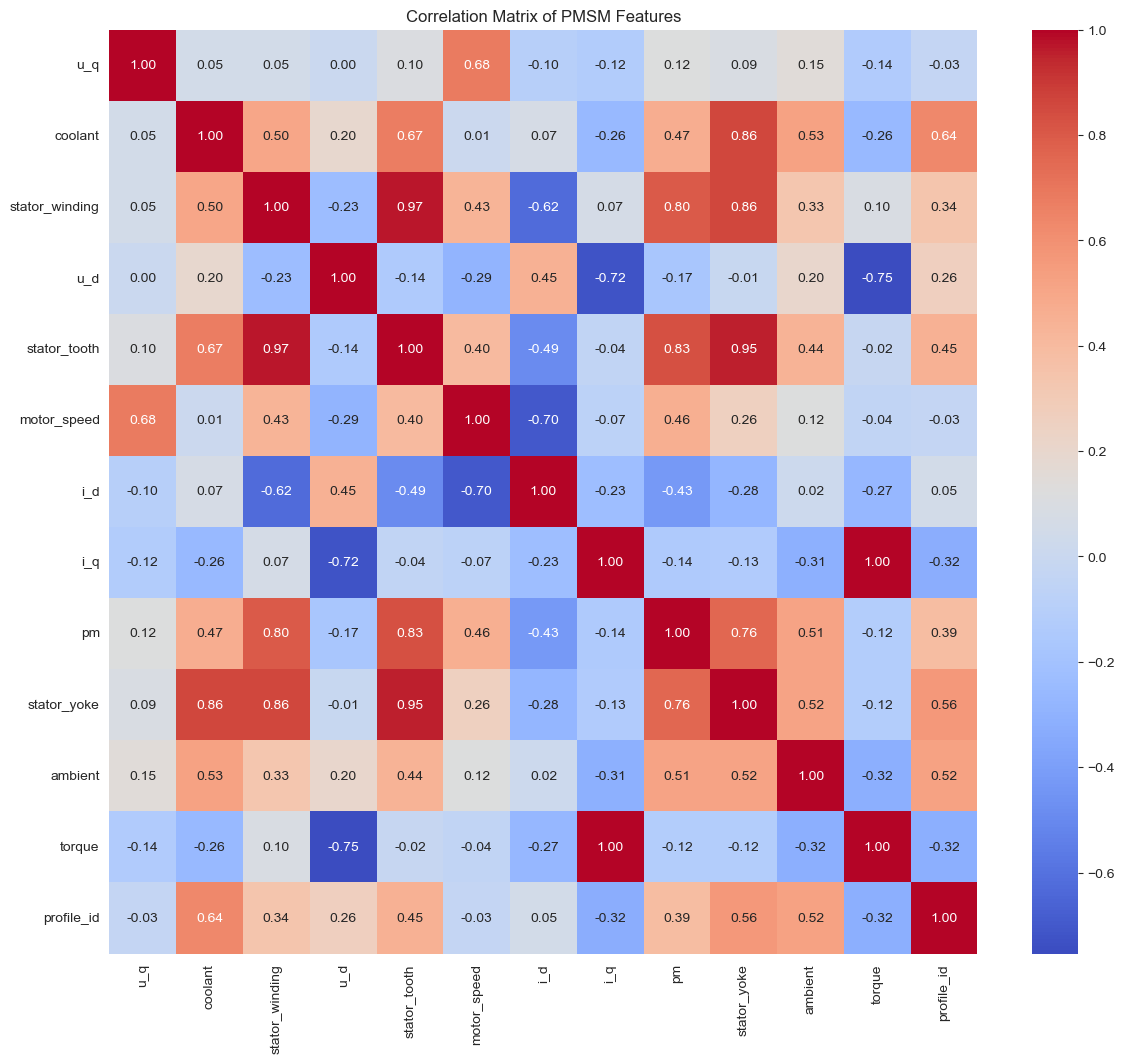


--- Correlation with Target Variable (pm) ---
pm                1.000000
stator_tooth      0.832084
stator_winding    0.795893
stator_yoke       0.756684
ambient           0.513793
coolant           0.467118
motor_speed       0.458949
profile_id        0.386242
u_q               0.122367
torque           -0.117137
i_q              -0.142415
u_d              -0.172033
i_d              -0.427736
Name: pm, dtype: float64


In [11]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of PMSM Features')
plt.show()

# Specifically, look at correlations with the target variable 'pm'
print("\n--- Correlation with Target Variable (pm) ---")
print(correlation_matrix['pm'].sort_values(ascending=False))

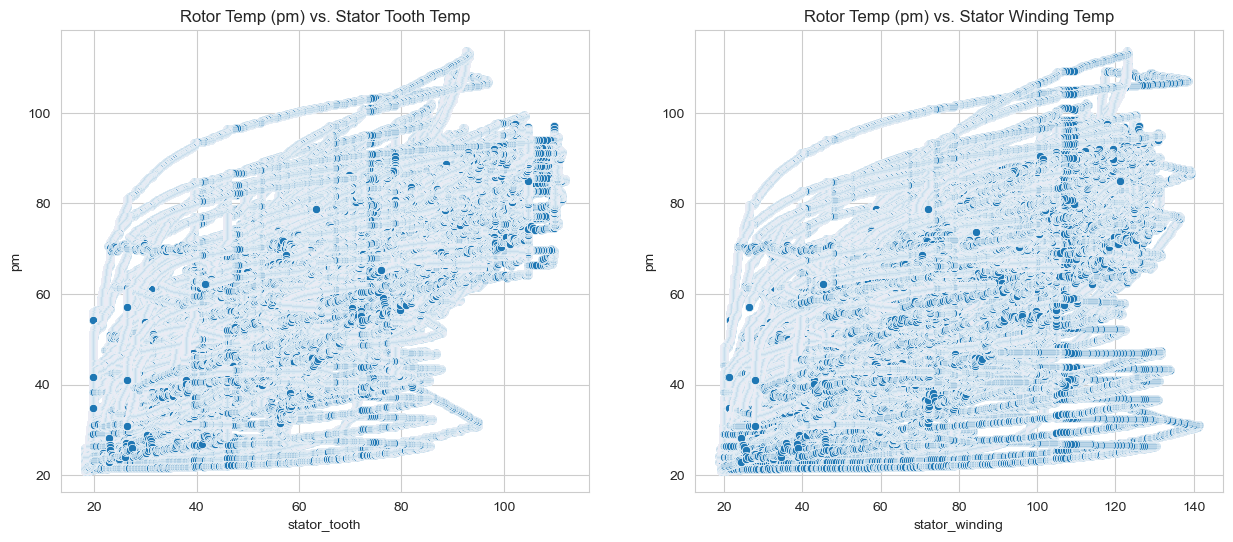

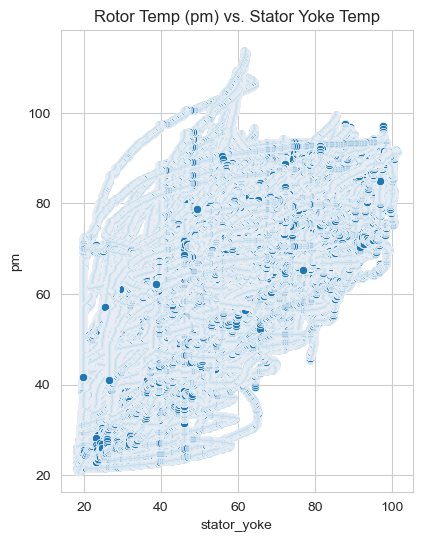

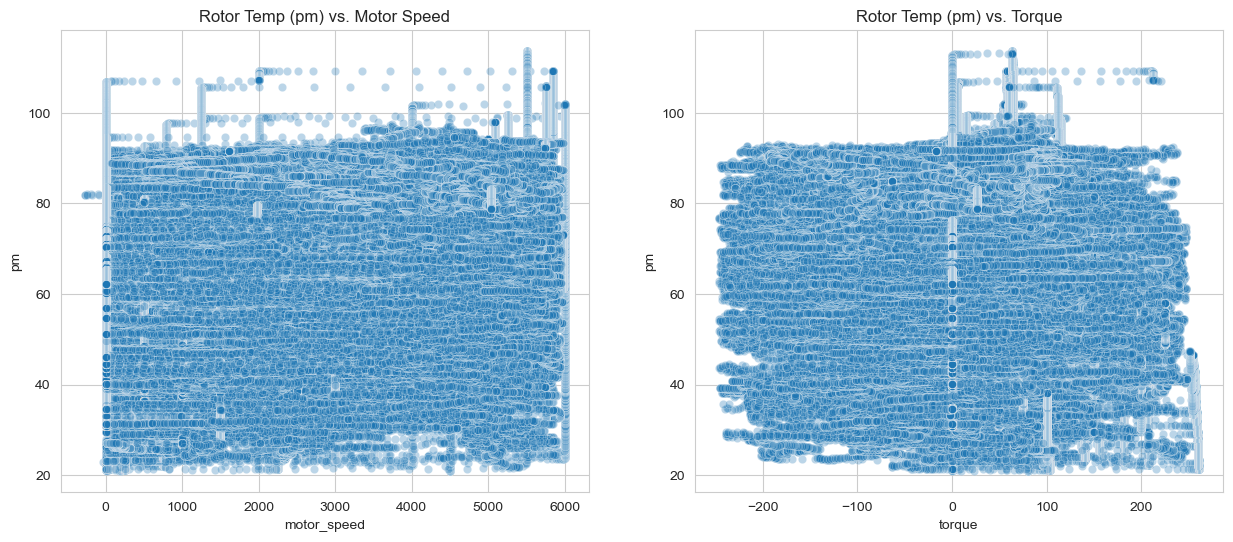

In [12]:
# Scatter plot of the three strongest predictors vs. the target
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='stator_tooth', y='pm', data=data)
plt.title('Rotor Temp (pm) vs. Stator Tooth Temp')

plt.subplot(1, 2, 2)
sns.scatterplot(x='stator_winding', y='pm', data=data)
plt.title('Rotor Temp (pm) vs. Stator Winding Temp')
plt.show()

plt.subplot(1, 2, 2)
sns.scatterplot(x='stator_yoke', y='pm', data=data)
plt.title('Rotor Temp (pm) vs. Stator Yoke Temp')
plt.show()

# Scatter plot of a key operational parameter vs. the target
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='motor_speed', y='pm', data=data, alpha=0.3) # Use alpha for dense plots
plt.title('Rotor Temp (pm) vs. Motor Speed')

plt.subplot(1, 2, 2)
sns.scatterplot(x='torque', y='pm', data=data, alpha=0.3)
plt.title('Rotor Temp (pm) vs. Torque')
plt.show()

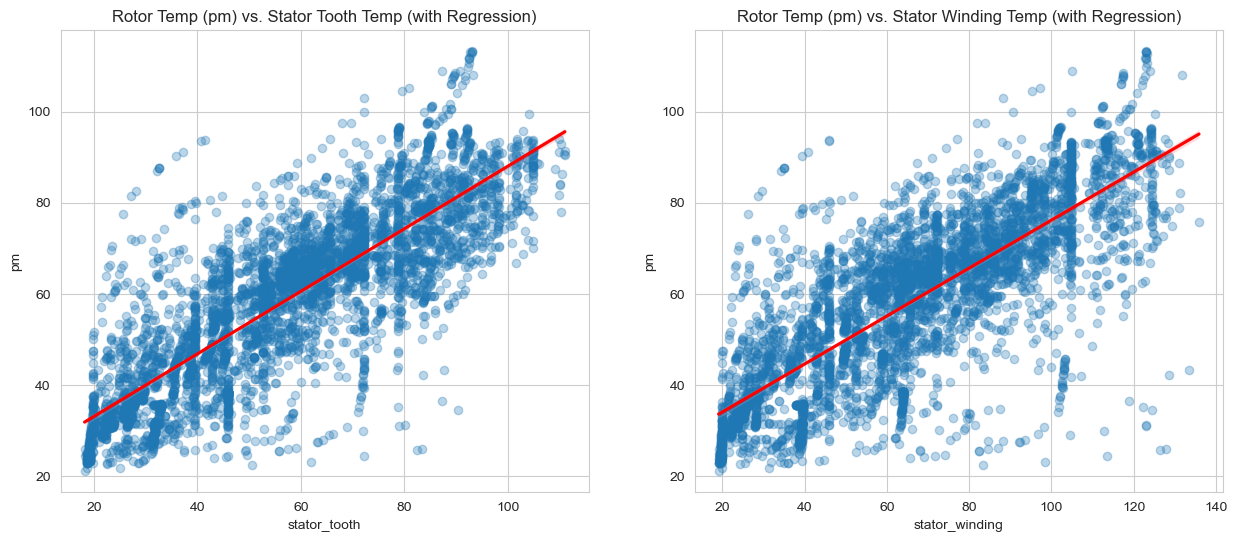

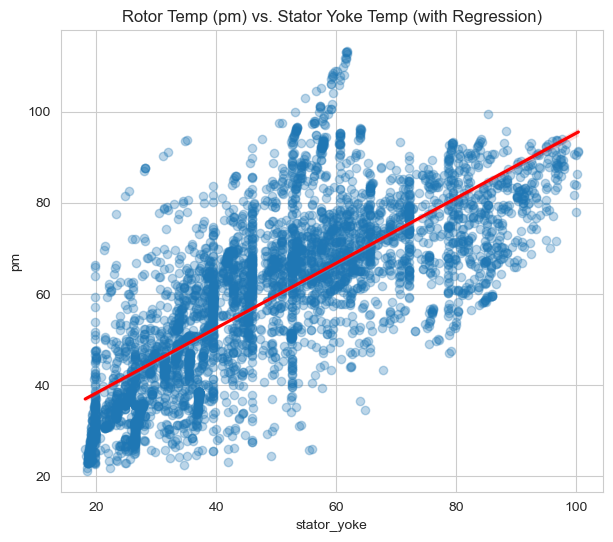

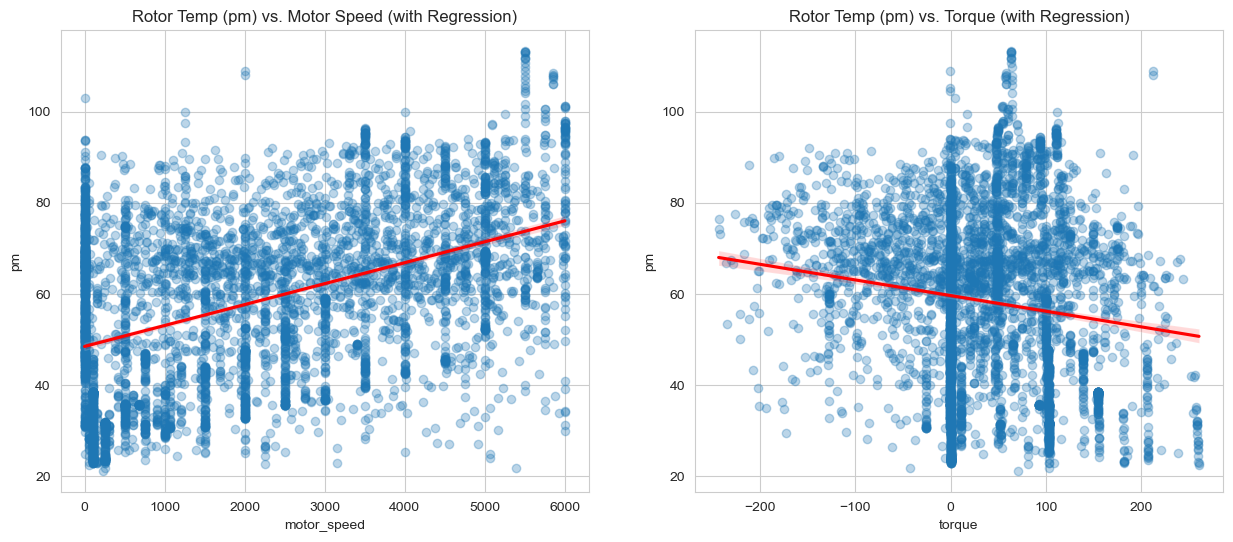

In [13]:


# Sample to avoid slowdown in plotting
sampled_data = data.sample(n=5000, random_state=42)

# Scatter + regression for the three strongest predictors
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.regplot(
    x='stator_tooth', y='pm', data=sampled_data,
    scatter_kws={'alpha':0.3}, line_kws={'color':'red'}
)
plt.title('Rotor Temp (pm) vs. Stator Tooth Temp (with Regression)')

plt.subplot(1, 2, 2)
sns.regplot(
    x='stator_winding', y='pm', data=sampled_data,
    scatter_kws={'alpha':0.3}, line_kws={'color':'red'}
)
plt.title('Rotor Temp (pm) vs. Stator Winding Temp (with Regression)')
plt.show()

# Third predictor (stator_yoke)
plt.figure(figsize=(7, 6))
sns.regplot(
    x='stator_yoke', y='pm', data=sampled_data,
    scatter_kws={'alpha':0.3}, line_kws={'color':'red'}
)
plt.title('Rotor Temp (pm) vs. Stator Yoke Temp (with Regression)')
plt.show()

# Operational parameters with regression
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.regplot(
    x='motor_speed', y='pm', data=sampled_data,
    scatter_kws={'alpha':0.3}, line_kws={'color':'red'}
)
plt.title('Rotor Temp (pm) vs. Motor Speed (with Regression)')

plt.subplot(1, 2, 2)
sns.regplot(
    x='torque', y='pm', data=sampled_data,
    scatter_kws={'alpha':0.3}, line_kws={'color':'red'}
)
plt.title('Rotor Temp (pm) vs. Torque (with Regression)')
plt.show()


Data PreProcessing

In [14]:
# 'profile_id' is an identifier, not a predictive feature. Let's drop it.
data.drop(columns=['profile_id'], inplace=True)
print("\n'profile_id' column dropped.")
print("Remaining columns:", data.columns)


'profile_id' column dropped.
Remaining columns: Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque'],
      dtype='object')


In [15]:
# Create a feature for copper losses (proportional to current squared)
# I_mag^2 = i_d^2 + i_q^2
data['i_mag_sq'] = data['i_d']**2 + data['i_q']**2

# Create a feature for electrical power
# P_elec = u_d * i_d + u_q * i_q
data['p_elec'] = data['u_d'] * data['i_d'] + data['u_q'] * data['i_q']

# Create a feature for thermal gradient between stator and coolant
data['temp_diff_stator_coolant'] = data['stator_yoke'] - data['coolant']

print("\nNew features created: 'i_mag_sq', 'p_elec', 'temp_diff_stator_coolant'")
print(data[['i_d', 'i_q', 'i_mag_sq', 'u_d', 'u_q', 'p_elec', 'stator_yoke', 'coolant', 'temp_diff_stator_coolant']].head())


New features created: 'i_mag_sq', 'p_elec', 'temp_diff_stator_coolant'
        i_d       i_q      i_mag_sq       u_d       u_q    p_elec  \
0  0.004419  0.000328  1.963642e-05 -0.350055 -0.450682 -0.001695   
1  0.000606 -0.000785  9.838601e-07 -0.305803 -0.325737  0.000071   
2  0.001290  0.000386  1.812393e-06 -0.372503 -0.440864 -0.000651   
3  0.000026  0.002046  4.185383e-06 -0.316199 -0.327026 -0.000677   
4 -0.064317  0.037184  5.519281e-03 -0.332272 -0.471150  0.003852   

   stator_yoke    coolant  temp_diff_stator_coolant  
0    18.316547  18.805172                 -0.488625  
1    18.314955  18.818571                 -0.503616  
2    18.326307  18.828770                 -0.502462  
3    18.330833  18.835567                 -0.504734  
4    18.326662  18.857033                 -0.530371  


In [16]:
# Define the target variable
y = data['pm']

# Define the features (all columns except the target)
X = data.drop(columns=['pm'])

print("\nShape of feature matrix (X):", X.shape)
print("Shape of target vector (y):", y.shape)


Shape of feature matrix (X): (1330806, 14)
Shape of target vector (y): (1330806,)


In [17]:
from sklearn.model_selection import train_test_split

# Split the data
# test_size=0.2 means 20% of the data will be used for testing
# random_state=42 ensures that the split is the same every time you run the code, making results reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData has been split:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Data has been split:
X_train shape: (1064644, 14)
X_test shape: (266162, 14)


In [18]:
# --- Recommended Selective Approach ---

# Let's assume from our EDA, we decided that only ambient, coolant, and u_d have problematic outliers
# You should adjust this list based on your own box plot analysis.
features_to_cap = ['ambient', 'coolant', 'stator_tooth','stator_winding','stator_yoke','motor_speed']

print(f"\n--- Applying Outlier Capping to Selective Features: {features_to_cap} ---")

# Work on copies
X_train_capped_selective = X_train.copy()
X_test_capped_selective = X_test.copy()

# Iterate over only the selected columns
for col in features_to_cap:
    # Check if the column exists to avoid errors
    if col in X_train.columns:
        lower_bound = X_train[col].quantile(0.01)
        upper_bound = X_train[col].quantile(0.99)

        print(f"Capping feature '{col}': Lower bound={lower_bound:.2f}, Upper bound={upper_bound:.2f}")

        X_train_capped_selective[col] = X_train_capped_selective[col].clip(lower_bound, upper_bound)
        X_test_capped_selective[col] = X_test_capped_selective[col].clip(lower_bound, upper_bound)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")


print("\nSelected features have been checked and outliers have been capped.")

# Overwrite the original variables to proceed with this selectively capped data
X_train = X_train_capped_selective
X_test = X_test_capped_selective


--- Applying Outlier Capping to Selective Features: ['ambient', 'coolant', 'stator_tooth', 'stator_winding', 'stator_yoke', 'motor_speed'] ---
Capping feature 'ambient': Lower bound=19.85, Upper bound=28.57
Capping feature 'coolant': Lower bound=18.03, Upper bound=91.09
Capping feature 'stator_tooth': Lower bound=18.83, Upper bound=104.62
Capping feature 'stator_winding': Lower bound=19.54, Upper bound=124.40
Capping feature 'stator_yoke': Lower bound=18.81, Upper bound=95.42
Capping feature 'motor_speed': Lower bound=-0.00, Upper bound=5999.93

Selected features have been checked and outliers have been capped.


In [25]:
from sklearn.preprocessing import StandardScaler

# 1. Initialize the scaler
scaler = StandardScaler()

# 2. Fit the scaler on the training data and transform it
# .fit_transform() learns the scaling parameters (mean, std) and applies the transformation
X_train_scaled = scaler.fit_transform(X_train)

# 3. Use the FITTED scaler to transform the test data
# .transform() applies the already learned transformation. We DO NOT re-fit on the test data.
X_test_scaled = scaler.transform(X_test)

print("\nFeatures have been scaled using StandardScaler.")

# The output is a NumPy array, so let's convert it back to a DataFrame for inspection
# The NEW, CORRECTED code
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
print("Scaled training data mean (should be ~0):")
print(X_train_scaled.mean().head())

# Check the standard deviation of the scaled training data
print("\nScaled training data standard deviation (should be ~1):")
print(X_train_scaled.std().head())


Features have been scaled using StandardScaler.
Scaled training data mean (should be ~0):
u_q              -2.068070e-16
coolant           2.838516e-16
stator_winding   -1.066571e-15
u_d              -1.588411e-17
stator_tooth      4.193537e-16
dtype: float64

Scaled training data standard deviation (should be ~1):
u_q               1.0
coolant           1.0
stator_winding    1.0
u_d               1.0
stator_tooth      1.0
dtype: float64


In [26]:
# 1. Initialize the Models
# We'll store our models in a dictionary for easy iteration.
# random_state=42 is used for reproducibility.
# n_jobs=-1 tells RandomForest to use all available CPU cores for faster training.

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Support Vector Machine (SVR)": SVR()
}

In [27]:
print("--- Training and Evaluating: Linear Regression ---")

# 1. Instantiate the model
lr_model = LinearRegression()

# 2. Select the SCALED data
X_train_data = X_train_scaled
X_test_data = X_test_scaled

# 3. Train the model
lr_model.fit(X_train_data, y_train)

# 4. Make predictions
lr_predictions = lr_model.predict(X_test_data)

# 5. Evaluate and store performance
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_r2 = r2_score(y_test, lr_predictions)

print(f"Mean Absolute Error (MAE): {lr_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.4f}")
print(f"R-squared (R²): {lr_r2:.4f}\n")

--- Training and Evaluating: Linear Regression ---
Mean Absolute Error (MAE): 5.4368
Root Mean Squared Error (RMSE): 7.2233
R-squared (R²): 0.8557



In [28]:
print("--- Training and Evaluating: Decision Tree Regressor ---")

# 1. Instantiate the model
dt_model = DecisionTreeRegressor(random_state=42)

# 2. Select the ORIGINAL (unscaled) data
X_train_data = X_train
X_test_data = X_test

# 3. Train the model
dt_model.fit(X_train_data, y_train)

# 4. Make predictions
dt_predictions = dt_model.predict(X_test_data)

# 5. Evaluate and store performance
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_predictions))
dt_r2 = r2_score(y_test, dt_predictions)

print(f"Mean Absolute Error (MAE): {dt_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {dt_rmse:.4f}")
print(f"R-squared (R²): {dt_r2:.4f}\n")

--- Training and Evaluating: Decision Tree Regressor ---
Mean Absolute Error (MAE): 0.1330
Root Mean Squared Error (RMSE): 0.8104
R-squared (R²): 0.9982



In [29]:
print("--- Training and Evaluating: Random Forest Regressor ---")

# 1. Instantiate the model
rf_model = RandomForestRegressor(
    n_estimators=20,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

# 2. Select the ORIGINAL (unscaled) data
X_train_data = X_train
X_test_data = X_test

# 3. Train the model
rf_model.fit(X_train_data, y_train)

# 4. Make predictions
rf_predictions = rf_model.predict(X_test_data)

# 5. Evaluate and store performance
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"R-squared (R²): {rf_r2:.4f}\n")

--- Training and Evaluating: Random Forest Regressor ---
Mean Absolute Error (MAE): 4.0851
Root Mean Squared Error (RMSE): 5.9059
R-squared (R²): 0.9035



In [30]:
print("--- Training and Evaluating: Support Vector Machine (SVR) on a Sample ---")

# 1. Instantiate the model with your chosen hyperparameters
svm_model = SVR(kernel='rbf', C=10, gamma='scale')

# 2. Define the full test set that we will use for prediction
# This line fixes the error.
X_test_data = X_test_scaled

# 3. Create a smaller, random sample for TRAINING to improve speed.
#    Using new variable names like `_sample` makes the code's intent clearer.
print("Creating a sample of 5000 data points for SVR training...")
X_train_sample = X_train_scaled.sample(n=5000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]  # This correctly matches labels to the sampled features

# 4. Train the model on the SAMPLE data
print("Training the SVR model (this may still take a moment)...")
svm_model.fit(X_train_sample, y_train_sample)

# 5. Make predictions on the FULL test set
print("Making predictions on the full test set...")
svm_predictions = svm_model.predict(X_test_data)

# 6. Evaluate and store performance
svm_mae = mean_absolute_error(y_test, svm_predictions)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))
svm_r2 = r2_score(y_test, svm_predictions)

print("\n--- SVR Results (Trained on Sample) ---")
print(f"Mean Absolute Error (MAE): {svm_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {svm_rmse:.4f}")
print(f"R-squared (R²): {svm_r2:.4f}\n")

--- Training and Evaluating: Support Vector Machine (SVR) on a Sample ---
Creating a sample of 5000 data points for SVR training...
Training the SVR model (this may still take a moment)...
Making predictions on the full test set...

--- SVR Results (Trained on Sample) ---
Mean Absolute Error (MAE): 4.2598
Root Mean Squared Error (RMSE): 6.2893
R-squared (R²): 0.8906



In [31]:
# Manually create the results dictionary from the stored variables
results_dict = {
    "Linear Regression": {'MAE': lr_mae, 'RMSE': lr_rmse, 'R-squared': lr_r2},
    "Decision Tree": {'MAE': dt_mae, 'RMSE': dt_rmse, 'R-squared': dt_r2},
    "Random Forest": {'MAE': rf_mae, 'RMSE': rf_rmse, 'R-squared': rf_r2},
    "Support Vector Machine (SVR)": {'MAE': svm_mae, 'RMSE': svm_rmse, 'R-squared': svm_r2}
}

# Convert to a DataFrame and sort
results_df = pd.DataFrame(results_dict).T
results_df_sorted = results_df.sort_values(by='RMSE', ascending=True)

print("\n--- Final Model Comparison ---")
print(results_df_sorted)



--- Final Model Comparison ---
                                   MAE      RMSE  R-squared
Decision Tree                 0.132980  0.810401   0.998184
Random Forest                 4.085129  5.905912   0.903540
Support Vector Machine (SVR)  4.259761  6.289291   0.890611
Linear Regression             5.436812  7.223320   0.855707


In [33]:
import pickle

# This code assumes you have the following variables ready in your environment:
# best_rf_model: The trained model from RandomizedSearchCV.
# scaler: The StandardScaler object fitted on the training data in Phase 2.

# --- 1. Save the Tuned Random Forest Model ---

# Define a descriptive filename for the model
model_filename = 'pmsm_random_forest_model.pkl'

# Use the 'with open' statement for safe file handling
# 'wb' means "write bytes," which is required for pickle
with open(model_filename, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"Model successfully saved to '{model_filename}'")


# --- 2. Save the Scaler ---

# Define a filename for the scaler
scaler_filename = 'pmsm_scaler.pkl'

# Save the scaler object using the same method
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

print(f"Scaler successfully saved to '{scaler_filename}'")

Model successfully saved to 'pmsm_random_forest_model.pkl'
Scaler successfully saved to 'pmsm_scaler.pkl'
